# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, I analyzed demographics data for customers of a mail-order.I have used unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describes the core customer base of the company. Then I applied what I had learned from unsupervised learning on a third dataset with demographics information for targets of a marketing campaign for the company, and use a supervised model to predict which individuals are most likely to convert into becoming customers for the company. The data that  has been provided by our Udacity's partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The project has couple of major steps. Since the CRISP-DM method is very handy and useful for data exploration, I followed the procedure as well here in my analysis. This report consists of the following parts:

### Part 0: Get to Know the Data
* Import Libraries and Load the data
* Finding data types and missing values
* Data Preprocessing
    * Drop not described features
    * Convert missing or unknown values to NaN
    * Drop columns because of too many NaNs
    * Drop rows because of too many NaNs
    * Select and re-encode features(categorical and mixed)
    * Feature scaling
    * Bulid a generic cleaning function including above steps for customer data

### Part 1: Customer Segmentation Report
* Principal Component Analysis
* Interpret Principal Components
    * The components with highest ranking(higher explained variance) are taken inconsidered to interpret features and their properties.
* Clustering and Evaluation
    * Apply k-means method for clustering to identify the population segment and customer segment in number of clusters. This helped to understand who are more likely to be target for marketing and become potential customers.
    * Analyse features' weight in overrepresented and underrepresented group of customers in clusters.

### Part 2: Supervised Learning Model
* Data preprocessing for new mail_out data set
* Model training
    * Logistic regression
    * RandomForestClassifier
    * GradientBoostingClassifier
    * AdaBoostClassifier
* Model Tuning 
* Feature Importance

### Part 3: Kaggle Competetion
Now that I've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle.Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.




In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# magic word for producing visualizations in notebook
%matplotlib inline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA 
import pprint
from sklearn.cluster import KMeans
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
%%time
# load in the data

azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';',dtype={18:'str',19:'str'})
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';',dtype={18:'str',19:'str'})

CPU times: user 49.3 s, sys: 16.4 s, total: 1min 5s
Wall time: 1min 8s


In [5]:
# View the dataset
pd.set_option('display.max_columns', None)
azdias.head()


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [7]:
##check data type
pd.options.display.max_rows = None
null_values_percent_azdias = (azdias.isnull().sum()/len(azdias))*100

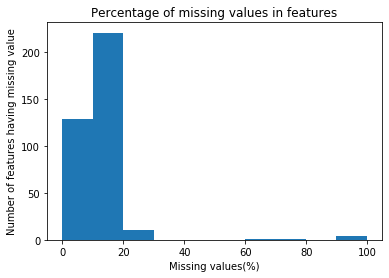

In [9]:
#Visualize the null value presence in general population dataset
plt.hist(null_values_percent_azdias.sort_values());
plt.title('Percentage of missing values in features')
plt.xlabel('Missing values(%)')
plt.ylabel('Number of features having missing value');

### Obviously there are many NaN value or missing values in both datasets. Let's assess more in population dataset and formulate cleaning function at the end to appy on customers dataset.

## Data Preprocessing(General population-Azdias)

### Step 1: Drop not described features
After looking into the details of the descriptive files an additional comma-separated values file was created manually. It took significant amount of time to create since both general population and customer files have more attributes than the descriptive files.

It sorts the features alphabetically, and maps both a type (categorical, mixed, numeric, ordinal) and values corresponding to missing information to each feature. The main issue during the file creation was the discrepancy between the features in the datasets and the descriptive files. For example features had slightly different names. But more important not all features could be found in the descriptive files. On the basis of further evaluation missing descriptions could be complemented.

In [10]:
# read in feature info file
feat_info = pd.read_csv('./Features_info.csv', sep=';', names=['Feature', 'Type', 'Unknown'])
feat_list = feat_info['Feature'].tolist()

In [11]:
feat_info.head(15)

,Feature,Type,Unknown
0,AGER_TYP,categorical,"[-1,0]"
1,ALTERSKATEGORIE_FEIN,ordinal,"[-1,0]"
2,ALTERSKATEGORIE_GROB,ordinal,"[-1,0,9]"
3,ALTER_HH,ordinal,[0]
4,ANREDE_KZ,categorical,"[-1,0]"
5,ANZ_HAUSHALTE_AKTIV,numeric,[]
6,ANZ_HH_TITEL,numeric,[]
7,ANZ_KINDER,numeric,[]
8,ANZ_PERSONEN,numeric,[]
9,ANZ_STATISTISCHE_HAUSHALTE,numeric,[]


In [12]:
# should be an empty array
diff_not_in_feat = list(set(feat_list) - set(azdias))
print('Features in feat_list that are not in azdias:')
print(len(diff_not_in_feat))
print(diff_not_in_feat)
print('***')

# features that are not in feat_info (no information regarding type)
diff_not_in_azdias = list(set(azdias) - set(feat_list))
print('Features in azdias that are not in feat_list:')
print(len(diff_not_in_azdias))
print(diff_not_in_azdias)
print('***')

# should be ['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP']
diff_customers_azdias = list(set(customers) - set(azdias))
print('Features in customers that are not in azdias:')

Features in feat_list that are not in azdias:
0
[]
***
Features in azdias that are not in feat_list:
32
['D19_KONSUMTYP_MAX', 'RT_KEIN_ANREIZ', 'LNR', 'VK_DHT4A', 'VHN', 'ALTER_KIND2', 'VK_ZG11', 'RT_SCHNAEPPCHEN', 'STRUKTURTYP', 'RT_UEBERGROESSE', 'VHA', 'CJT_TYP_2', 'ALTER_KIND4', 'CJT_TYP_1', 'ALTER_KIND1', 'D19_LETZTER_KAUF_BRANCHE', 'CJT_TYP_3', 'CJT_KATALOGNUTZER', 'UMFELD_ALT', 'GEMEINDETYP', 'VERDICHTUNGSRAUM', 'CJT_TYP_5', 'CJT_TYP_4', 'EXTSEL992', 'EINGEFUEGT_AM', 'CJT_TYP_6', 'UMFELD_JUNG', 'FIRMENDICHTE', 'AKT_DAT_KL', 'KOMBIALTER', 'VK_DISTANZ', 'ALTER_KIND3']
***
Features in customers that are not in azdias:


In [13]:
diff_not_in_customers = list(set(customers) - set(feat_list))
print('Features in customers that are not in feat_list:')
print(len(diff_not_in_customers))
print(diff_not_in_customers)
print('***')

Features in customers that are not in feat_list:
35
['D19_KONSUMTYP_MAX', 'RT_KEIN_ANREIZ', 'LNR', 'VK_DHT4A', 'VHN', 'ALTER_KIND2', 'VK_ZG11', 'RT_SCHNAEPPCHEN', 'STRUKTURTYP', 'RT_UEBERGROESSE', 'VHA', 'CJT_TYP_2', 'ALTER_KIND4', 'CJT_TYP_1', 'ALTER_KIND1', 'D19_LETZTER_KAUF_BRANCHE', 'CJT_TYP_3', 'CJT_KATALOGNUTZER', 'UMFELD_ALT', 'GEMEINDETYP', 'VERDICHTUNGSRAUM', 'CJT_TYP_5', 'CUSTOMER_GROUP', 'CJT_TYP_4', 'PRODUCT_GROUP', 'EXTSEL992', 'EINGEFUEGT_AM', 'CJT_TYP_6', 'UMFELD_JUNG', 'FIRMENDICHTE', 'AKT_DAT_KL', 'KOMBIALTER', 'VK_DISTANZ', 'ONLINE_PURCHASE', 'ALTER_KIND3']
***


In [14]:
# drop features
azdias.drop(labels=diff_not_in_azdias, axis=1, inplace=True)

In [15]:
azdias.shape

(891221, 334)

### Step 2: Convert missing or unknown values to NaN
The manually created feature info file contains all values corresponding to missing information. Additionally to the already existing NaN values in the datasets these placeholders have to be converted to NaN values.

In [16]:
unknown = pd.Series(feat_info['Unknown'].values, index=feat_info['Feature'])
unknown

Feature
AGER_TYP                            [-1,0]
ALTERSKATEGORIE_FEIN                [-1,0]
ALTERSKATEGORIE_GROB              [-1,0,9]
ALTER_HH                               [0]
ANREDE_KZ                           [-1,0]
ANZ_HAUSHALTE_AKTIV                     []
ANZ_HH_TITEL                            []
ANZ_KINDER                              []
ANZ_PERSONEN                            []
ANZ_STATISTISCHE_HAUSHALTE              []
ANZ_TITEL                               []
ARBEIT                                 [9]
BALLRAUM                              [-1]
CAMEO_DEUG_2015                 ['-1','X']
CAMEO_DEU_2015                      ['XX']
CAMEO_INTL_2015                ['-1','XX']
CJT_GESAMTTYP                          [0]
D19_BANKEN_ANZ_12                      [0]
D19_BANKEN_ANZ_24                      [0]
D19_BANKEN_DATUM                      [10]
D19_BANKEN_DIREKT                      [0]
D19_BANKEN_GROSS                       [0]
D19_BANKEN_LOKAL                       [0]
D19

In [17]:
%%time
#imputing NaN values
for col in azdias:
    isin = ast.literal_eval(unknown[col])
    azdias[col] = azdias[col].mask(azdias[col].isin(isin), other=np.nan)

azdias.head()

CPU times: user 33 s, sys: 25.6 s, total: 58.6 s
Wall time: 33.5 s


,AGER_TYP,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,

### Step 3:Drop columns because of too many NaNs¶

In [18]:
%%time
# calculate the percentage of missing values per feature
missing_per_column = azdias.isnull().mean()

CPU times: user 5.22 s, sys: 10.7 s, total: 15.9 s
Wall time: 13 s


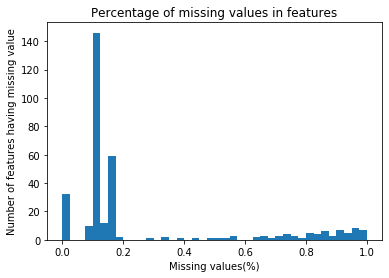

In [19]:
#plot missing value propotion per column
plt.hist(missing_per_column, bins=40);
plt.title('Percentage of missing values in features')
plt.xlabel('Missing values(%)')
plt.ylabel('Number of features having missing value');
plt.savefig('figure_missing_value%.png', bbox_inches='tight')


In [20]:
%%time
# features to be dropped have more than 20% missing values 
drop_missing_per_column = missing_per_column[missing_per_column > 0.2].index

# drop features
azdias.drop(labels=drop_missing_per_column, axis=1, inplace=True)
                                  

CPU times: user 701 ms, sys: 950 ms, total: 1.65 s
Wall time: 1.64 s


In [21]:
# what features have been dropped
drop_missing_per_column

Index(['AGER_TYP', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT',
       'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO',
       'D19_KINDERARTIKEL', 'D19_KONSUMTYP', 'D19_KOSMETIK',
       'D19_LEBENSMITTEL', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
       'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
       'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_ANZ_12',
       'D19_TELKO_ANZ_24'

In [22]:
azdias.shape

(891221, 261)

### Step 4: S Drop rows beacuase of too many NaNs

In [23]:
%%time
# calculate the percentage of missing values per individual
missing_per_row = azdias.isnull().sum(axis=1)

CPU times: user 974 ms, sys: 288 ms, total: 1.26 s
Wall time: 1.03 s


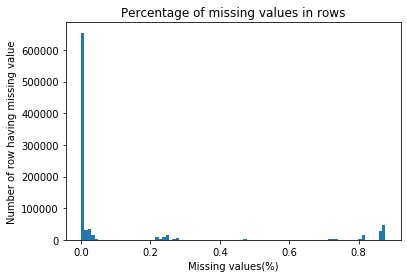

In [24]:
#Visulalize missing rows in the population dataset
plt.hist(missing_per_row / azdias.shape[1], bins=90)
plt.title('Percentage of missing values in rows')
plt.xlabel('Missing values(%)')
plt.ylabel('Number of row having missing value');
plt.savefig('figure_missing_row%.png', bbox_inches='tight')


In [25]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row (our threshold is 30% of missing values)
def split_dataset(df, missing_per_row, threshold=0.3):
    """
    Splits data into two subsets based on the missing values per row.

    INPUT:
    - df (DataFrame): DataFrame to be split
    - missing_per_row: calculated percentage of missing values per row
    - threshold (float): threshold as decision criteria for splitting

    OUTPUT:
    - DataFrame: DataFrame with a smaller percentage of missing values than the threshold 
    - DataFrame: DataFrame with a higher percentage of missing values than the threshold
    """
    above_th = df[missing_per_row / df.shape[1] <= threshold]
    below_th = df[missing_per_row / df.shape[1] > threshold]
    return above_th, below_th
    
azdias, azdias_row_nan = split_dataset(azdias, missing_per_row)

In [26]:
azdias.shape[0]/891221

0.8809902369894784

In [27]:
azdias_row_nan.shape

(106064, 261)

### Step 6: Select and Re-Encode Features

### Categorical Features

In [28]:
# how many categorical features do we have?
categorical = feat_info[feat_info['Type'] == 'categorical']
categorical.shape

(26, 3)

In [29]:
def access_features(feature_type):
    """
    Access features of a specific type.

    INPUT:
    - feature_type (str): feature type (categorical, mixed, numeric, ordinal)

    OUTPUT: None
    """
    
    for i in range (0, feat_info.shape[0]):
        t = feat_info.at[i,'Type']
        f = feat_info.at[i,'Feature']
        try:
            if(t == feature_type):
                print(f, azdias.loc[: , f].unique())
        except KeyError:
            print(f + ' was eliminated already')

In [30]:
# Assess categorical features
access_features('categorical')

AGER_TYP was eliminated already
ANREDE_KZ [2 1]
CAMEO_DEUG_2015 ['8.0' '4.0' '2.0' '6.0' '1.0' '9.0' '5.0' '7.0' '3.0' nan '4' '3' '7' '2'
 '8' '9' '6' '5' '1']
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '7A' '5D' '9E'
 '9B' '1B' '8B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
CJT_GESAMTTYP [ 5.  3.  2.  4.  1.  6. nan]
D19_KONSUMTYP was eliminated already
DSL_FLAG [1. 0.]
FINANZTYP [1 6 5 2 4 3]
GEBAEUDETYP [8. 1. 3. 2. 6. 4. 5.]
GFK_URLAUBERTYP [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
GREEN_AVANTGARDE [0 1]
HH_DELTA_FLAG [ 0. nan  1.]
KK_KUNDENTYP was eliminated already
KONSUMZELLE [ 1.  0. nan]
LP_FAMILIE_FEIN [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB [ 3.  1. nan  5.  2.  4.]
LP_STATUS_FEIN [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
LP_STATUS_GROB [ 1.  2.  4.  5.  3. nan]
NATIONALITAET_KZ [ 1.  3.  2. nan]
OST_WEST_K

In [31]:
# Re-encode categorical variable(s) to be kept in the analysis.
# 26 features, 4 dropped in steps before, 20 numerical - no changes (simplification)

# dummies for binary non-numerical
col_ow = azdias.loc[: , 'OST_WEST_KZ']
s_ow = pd.Series(col_ow)
azdias = pd.concat([azdias.drop('OST_WEST_KZ', axis=1), pd.get_dummies(s_ow, dummy_na=True, drop_first=True)], axis=1)

# drop fine features, rough features are still available
azdias.drop(['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN'], axis=1, inplace=True)

# CAMEO_DEUG_2015 as float
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype('float64')

In [32]:
azdias.shape

(785157, 259)

### Mixed Features

In [33]:
# how many mixed features do we have?
mixed = feat_info[feat_info['Type'] == 'mixed']
mixed.shape

(4, 3)

In [34]:
# Assess mixed features
access_features('mixed')

CAMEO_INTL_2015 ['51.0' '24.0' '12.0' '43.0' '54.0' '22.0' '14.0' '13.0' '15.0' '33.0'
 '41.0' '34.0' '55.0' '25.0' nan '23.0' '31.0' '52.0' '35.0' '45.0' '44.0'
 '32.0' '22' '24' '41' '12' '54' '51' '44' '35' '23' '25' '14' '34' '52'
 '55' '31' '32' '15' '13' '43' '33' '45']
LP_LEBENSPHASE_FEIN [21.  3. nan 32.  8.  2.  5. 10.  4.  6. 23. 20.  1. 25. 13. 18. 31. 38.
 35. 30.  7. 22. 14. 29. 24. 28. 37. 26. 12. 39. 27. 36.  9. 34. 33. 15.
 11. 40. 16. 19. 17.]
LP_LEBENSPHASE_GROB [ 6.  1. nan 10.  2.  3.  5.  7. 12. 11.  9.  4.  8.]
PRAEGENDE_JUGENDJAHRE [14. 15.  8.  3. 10. 11.  9.  6.  4. nan  5.  2.  1. 12. 13.  7.]


In [35]:
def convert_pj_to_dec(val):
    """
    Converts value of feature PRAEGENDE_JUGENDJAHRE to a DECADE value.

    INPUT:
    - val (int): original value

    OUTPUT:
    - int: converted value (0: 40s, 1: 50s, 2: 60s, 3: 70s, 4: 80s, 5: 90s)
    """
    
    result = val
    if (val > 0 and val <= 2):
        result = 0 #40s
    elif (val <= 4):
        result = 1 #50s
    elif (val <= 7):
        result = 2 #60s
    elif (val <= 9):
        result = 3 #70s
    elif (val <= 13):
        result = 4 #80s
    elif (val <= 15):
        result = 5 #90
    return result

def convert_pj_to_move(val):
    """
    Converts value of feature PRAEGENDE_JUGENDJAHRE to a MOVEMENT value.

    INPUT:
    - val (int): original value

    OUTPUT:
    - int: converted value (0: Mainstream, 1: Avantgarde)
    """
    result = val
    if (val in [1,3,5,8,10,12,14]):
        result = 0 # M
    elif (val in [2,4,6,7,9,11,13,15]):
        result = 1 # A
    return result

In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias['DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_pj_to_dec(x))
azdias['MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_pj_to_move(x))

# drop PRAEGENDE_JUGENDJAHRE
azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [37]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

# drop CAMEO_INTL_2015
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [38]:
# drop LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB because no clear structure available
azdias.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)

In [39]:
azdias.shape

(785157, 259)

### Feature Scaling
Missing values are imputed with the median of the corresponding feature. Because of the majority of categorical and ordinal features it is superior to imputing mean values. Afterwards the features were standardised.

In [40]:
imputer = Imputer(strategy='median')
scaler = StandardScaler()



/Users/lailashahreen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [41]:
#impute median and scale azdias
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias),columns = azdias.columns)
azdias_scaled_arr = scaler.fit_transform(azdias_imputed)

azdias_scaled = pd.DataFrame(azdias_scaled_arr, columns = azdias.columns, index = azdias.index)


### Put it all together -Cleaning Function

In [42]:
def clean_data(df, feat_info, drop_not_described, drop_nan_col, split=False):
    """
    Cleans a DataFrame including the following steps:
    - Drop not described features
    - Convert missing values
    - Drop features with high percentage of missing values
    - Drop rows with high percentage of unknown values (optional)
    - Re-encode features

    INPUT:
    - df (DataFrame): the DataFrame to be cleaned
    - feat_info (DataFrame): the DataFrame containing the feature information
    - drop_not_described (list): list of features to be dropped because they are not contained in the feature info
    - drop_nan_col (list): list of features to be dropped because of a high percentage of missing values
    - split (bool): if True rows with a high percentage of missing values are extracted

    OUTPUT:
    - DataFrame: cleaned DataFrame
    - DataFrame (only if split=True): DataFrame containing rows with many missing values
    """
    
    # drop features that are not described
    df.drop(labels=drop_not_described, axis=1, inplace=True)
    
    # convert missing or unknown
    unknown = pd.Series(feat_info['Unknown'].values, index=feat_info['Feature'])
    for col in df:
        isin = ast.literal_eval(unknown[col])
        df[col] = df[col].mask(df[col].isin(isin), other=np.nan)
    
    # drop columns because of too many NaN
    df.drop(labels=drop_nan_col, axis=1, inplace=True)
    
    # split if necessary
    df_row_nan = pd.DataFrame()
    if(split):
        missing_per_row = df.isnull().sum(axis=1)
        df, df_row_nan = split_dataset(df, missing_per_row)
    
    # Re-encode categorical features
    # dummies for binary non-numerical
    col_ow = df.loc[: , 'OST_WEST_KZ']
    s_ow = pd.Series(col_ow)
    df = pd.concat([df.drop('OST_WEST_KZ', axis=1), pd.get_dummies(s_ow, dummy_na=True, drop_first=True)], axis=1)

    # drop fine features
    df.drop(['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN'], axis=1, inplace=True)

    # CAMEO_DEUG_2015 as float
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float64')
    
    # Re-encode mixed features
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_pj_to_dec(x))
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: convert_pj_to_move(x))

    # drop PRAEGENDE_JUGENDJAHRE
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor(pd.to_numeric(x)/10))
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: pd.to_numeric(x)%10)

    # drop CAMEO_INTL_2015
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # drop LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB because no clear structure available
    df.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
    
    if(split):
        return df, df_row_nan
    else:
        return df

### Customer Data Preprocessing

In [43]:
# for customers three additional columns have to be dropped before cleaning
customers.drop(diff_customers_azdias, axis=1, inplace=True)

In [44]:
# clean data
customers, customers_row_nan = clean_data(customers, feat_info, diff_not_in_azdias, drop_missing_per_column, split=True)
customers.shape

(140343, 259)

In [45]:
customers.shape[0]/191652

0.7322803831945401

In [46]:
# impute median and scale customers, use already existing imputer and scaler objects
customers_imputed = pd.DataFrame(imputer.transform(customers),columns =customers.columns)
customers_scaled_arr = scaler.transform(customers_imputed)
customers_scaled = pd.DataFrame(customers_scaled_arr, columns = customers.columns, index = customers.index)



## Part 1: Customer Segmentation Report
The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### PCA
For clustering a PCA is not necessarily a precondition, but it reduces noise and therefore clustering methods are better able to distinguish the different clusters.

In [47]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    """
    Creates a scree plot associated with the principal components. 
    
    INPUT:
    - pca (PCA): the result of instantiation of PCA in scikit learn
            
    OUTPUT: None
    """
    
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

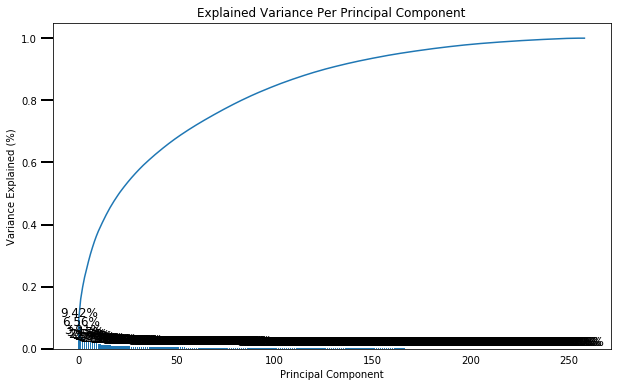

In [48]:
# Apply PCA to the data
pca_full = PCA()
X_azdias_pca_full = pca_full.fit_transform(azdias_scaled)
scree_plot(pca_full)

CPU times: user 1min 22s, sys: 31.5 s, total: 1min 54s
Wall time: 1min 26s


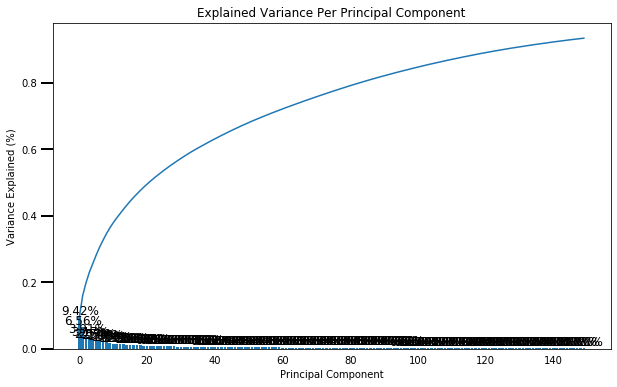

In [49]:
%%time
# Re-apply PCA to the data while selecting for number of components to retain
pca_150 = PCA(n_components=150, random_state=12)
X_azdias_pca = pca_150.fit_transform(azdias_scaled)
scree_plot(pca_150)
plt.savefig('pca_150.png', bbox_inches='tight')

There is no clear cut way to choose the number of components to keep when performing PCA. By looking around forums as well as this teaching document (http://www.octoberraindrops.com/publications/Phan_2016_IntroductionToPCA.pdf), it has been suggested to keep the number of components which captures at least 85% of the variability of the data. In addition, another way to decide on the number of components is to look at the "elbow", or where the scree plot line curves such that you begin to get diminishing returnings of the amount of variance explained per addition of an additional component. Therefore, based on these 2 ideas, I have chosen to use 150 components which explains more than 85% of the variance and at this point the line on the scree plot starts to plateau.

## Interpret Principal Components
From term 1 project: Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate. You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the i-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [174]:
# this function is taken from the classroom
def get_weights(pca, component_num, data):
    '''
    This function delivers the weights of principal component per features
    Input : scaled dataframe, component number and final pca function after dimensional reduction
    Output: Weights per feature in each component
    '''
    df = pd.DataFrame(pca.components_, columns = list(data.columns))
    weights = df.iloc[component_num].sort_values(ascending=False)
    return weights

In [67]:
# print relationship between azdias features and pca components
dimensions = len(pca_150.components_)
result = pd.DataFrame()
for dim in range(dimensions):
    df = get_weights(pca_150, dim, azdias_scaled)
    result = pd.concat([result, df], axis = 1)
result = result.T
result

/Users/lailashahreen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,ANZ_HAUSHALTE_AKTIV,ANZ_STATISTISCHE_HAUSHALTE,ARBEIT,CAMEO_DEUG_2015,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_HAUSBAUER,FINANZ_SPARER,GEBAEUDETYP,GFK_URLAUBERTYP,HH_EINKOMMEN_SCORE,KBA05_ALTER1,KBA05_ANTG3,KBA05_ANTG4,KBA05_CCM1,KBA05_KW1,KBA05_MAXHERST,KBA05_MAXVORB,KBA05_VORB2,KBA05_ZUL1,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1400,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HERST_ASIEN,KBA13_HERST_EUROPA,KBA13_HERST_SONST,KBA13_KMH_180,KBA13_KW_0_60,KBA13_KW_40,KBA13_KW_50,KBA13_MAZDA,KBA13_NISSAN,KBA13_RENAULT,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_SONSTIGE,KBA13_SITZE_5,KBA13_VORB_2,KBA13_VORB_3,KKK,KONSUMZELLE,ORTSGR_KLS9,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,REGIOTYP,RELAT_AB,WEALTH,W_KEIT_KIND_HH,ZABEOTYP,ANZ_HH_TITEL,DECADE,FINANZ_ANLEGER,KBA05_ALTER2,KBA05_CCM2,KBA05_HERST4,KBA05_HERST5,KBA05_KRSHERST3,KBA05_SEG2,KBA05_SEG3,KBA13_CCM_1200,KBA13_CCM_1600,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KW_60,KBA13_PEUGEOT,KBA13_SEG_MITTELKLASSE,KBA13_TOYOTA,NATIONALITAET_KZ,PLZ8_HHZ,SEMIO_FAM,SEMIO_KAEM,SEMIO_KULT,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,VERS_TYP,ANREDE_KZ,CJT_GESAMTTYP,DSL_FLAG,HEALTH_TYP,KBA05_ANTG2,KBA05_HERST3,KBA05_HERSTTEMP,KBA05_KRSKLEIN,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_66,KBA13_HERST_FORD_OPEL,KBA13_KMH_110,KBA13_KMH_140,KBA13_KW_30,KBA13_KW_70,KBA13_SEG_MINIWAGEN,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_KRIT,SHOPPER_TYP,NaN,KBA05_MOD3,KBA13_OPEL,FINANZ_UNAUFFAELLIGER,SOHO_KZ,KBA13_VORB_1_2,KBA13_ALTERHALTER_61,ANZ_TITEL,KBA05_MODTEMP,KBA05_FRAU,KBA13_KW_80,UNGLEICHENN_FLAG,KBA13_CCM_1800,KBA13_MOTOR,FINANZTYP,KBA05_SEG4,KBA13_KW_90,KBA05_MOD4,KBA05_ZUL2,KBA13_SEG_OBERKLASSE,KBA05_SEG1,KBA05_MOD2,KBA05_VORB1,KBA13_CCM_1500,HH_DELTA_FLAG,KBA05_KRSVAN,KBA05_MAXSEG,KBA13_SITZE_4,SEMIO_LUST,SEMIO_ERL,KBA05_KRSHERST2,KBA13_BMW,ANZ_KINDER,KBA13_SEG_OBEREMITTELKLASSE,SEMIO_VERT,KBA13_KW_120,KBA05_KW2,KBA13_SEG_WOHNMOBILE,WOHNDAUER_2008,KBA13_HALTER_65,KBA13_SEG_SPORTWAGEN,KBA13_KMH_251,KBA13_BJ_2004,KBA13_VORB_1,ALTERSKATEGORIE_GROB,KBA05_SEG6,MIN_GEBAEUDEJAHR,KBA13_CCM_1401_2500,KBA13_CCM_3000,KBA13_KRSHERST_AUDI_VW,KBA05_ALTER4,KBA05_KRSOBER,KBA13_HERST_BMW_BENZ,KBA05_MAXBJ,KBA13_HALTER_45,KBA13_KW_121,KBA13_KMH_250,KBA13_KMH_211,KBA13_MERCEDES,FINANZ_VORSORGER,KBA05_ALTER3,KBA13_KMH_210,KBA13_CCM_2500,KBA05_KRSZUL,KBA05_MAXAH,KBA13_BJ_2009,KBA13_KW_110,KBA13_CCM_2501,KBA05_SEG8,KBA05_KRSHERST1,KBA05_VORB0,KBA13_BJ_2008,KBA05_ZUL4,KBA05_HERST2,KBA13_HALTER_20,KBA05_CCM4,KBA05_SEG5,KBA05_ZUL3,KBA13_CCM_3001,KBA13_SEG_UTILITIES,KBA13_KW_61_120,WOHNLAGE,KBA13_VORB_0,KBA05_HERST1,KBA13_KRSHERST_BMW_BENZ,KBA13_BJ_2006,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA05_KW3,ONLINE_AFFINITAET,KBA05_MOD1,LP_FAMILIE_GROB,ANZ_PERSONEN,KBA05_SEG9,KBA05_CCM3,KBA13_CCM_2000,KBA13_AUDI,KBA05_MOTOR,KBA05_SEG7,KBA13_VW,KBA13_KRSSEG_OBER,KBA05_MOD8,KBA13_SEG_MINIVANS,KBA13_ANZAHL_PKW,W,GEBAEUDETYP_RASTER,BALLRAUM,KBA05_DIESEL,KBA13_HERST_AUDI_VW,KBA05_SEG10,KBA13_HALTER_60,MOVEMENT,GREEN_AVANTGARDE,LIFE_STAGE,KBA05_MOTRAD,KBA13_SITZE_6,KBA13_SEG_VAN,KBA13_SEG_GROSSRAUMVANS,KBA05_KRSAQUOT,KBA13_KRSAQUOT,KBA13_HALTER_50,KBA13_SEG_GELAENDEWAGEN,INNENSTADT,KBA13_HALTER_55,KONSUMNAEHE,KBA13_ALTERHALTER_60,KBA05_ANHANG,FINANZ_MINIMALIST,PLZ8_GBZ,KBA13_GBZ,KBA05_AUTOQUOT,LP_STATUS_GROB,KBA05_GBZ,KBA13_AUTOQUOTE,MOBI_RASTER,KBA05_ANTG1,MOBI_REGIO,KBA13_ANTG1,PLZ8_ANTG1
0,0.086107,0.084488,0.110299,0.148742,0.036023,0.119702,0.110807,0.052398,0.041607,0.036727,0.138507,0.044194,0.092598,0.097896,0.038943,0.043709,0.044944,0.034466,0.040561,0.047131,0.086788,0.043716,0.077759,0.155797,0.153522,0.153102,0.047551,0.068540,0.051085,0.035084,0.040113,0.036816,0.053032,0.044956,0.109513,0.097686,0.042354,0.056132,0.045434,0.053032,0.048292,0.061962,0.038577,0.0345

In [146]:
def plot_weights_by_component(idx, pca_data):
    '''
    Create a dataframe of PCA results and show the PCA results where figure 1 shows 
    all features sorted and figure 2 shows the top 3 negative and positive features.
    '''
    df = pd.DataFrame(pca_data.loc[idx].sort_values().reset_index())
    #print(df)
    plt.rcParams["figure.figsize"] = [16,6]
    #plt.bar(result.loc[0].sort_values().index.tolist(), result.loc[0].sort_values().values.tolist())
    plt.bar(df.index.tolist(), result.loc[idx].sort_values().values.tolist())
    plt.title("Weight by feature by component")
    plt.xlabel("Feature")
    plt.ylabel("Feature Weight")
    plt.show()
    
    plt.rcParams["figure.figsize"] = [16,6]
    plt.bar(result.loc[idx].sort_values().iloc[[0, 1, 2, -3, -2, -1]].index.tolist(), 
            result.loc[idx].sort_values().iloc[[0, 1, 2, -3, -2, -1]].values.tolist())
    plt.title("Weight by feature by component")
    plt.xlabel("Feature")
    plt.ylabel("Feature Weight")
   
    

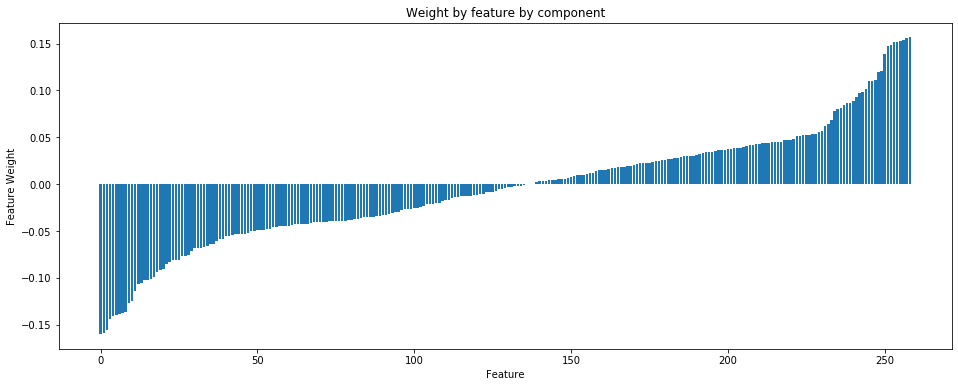

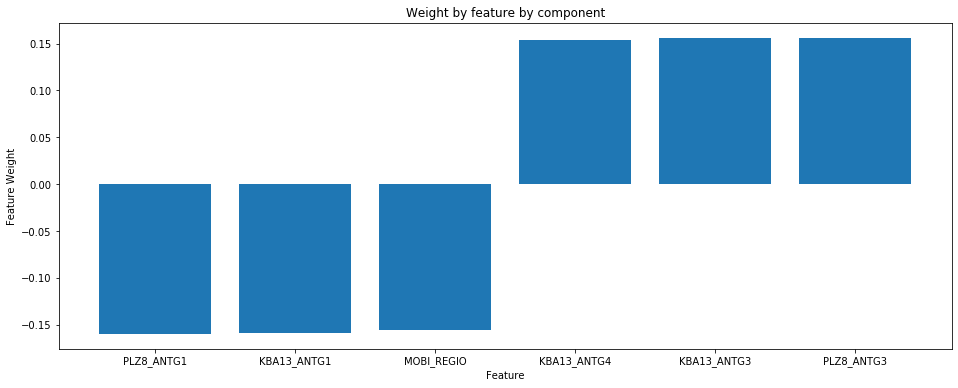

In [147]:

plot_weights_by_component(0, result)
plt.savefig('PC_1_Features_Weight.png',bbox_inches = 'tight')
plt.show()

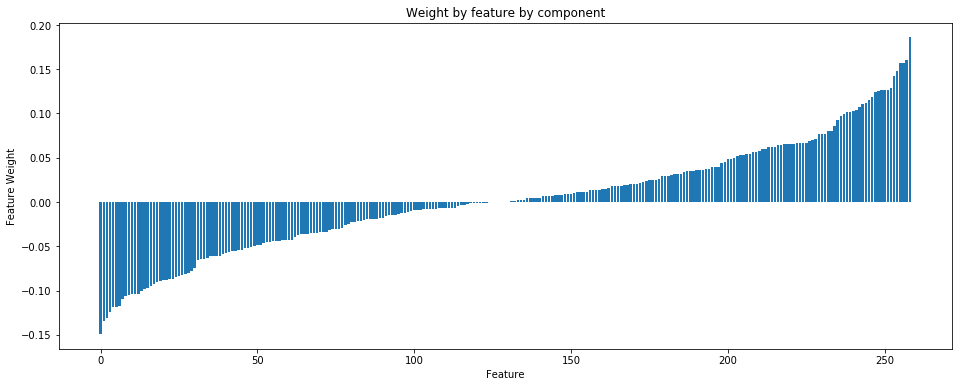

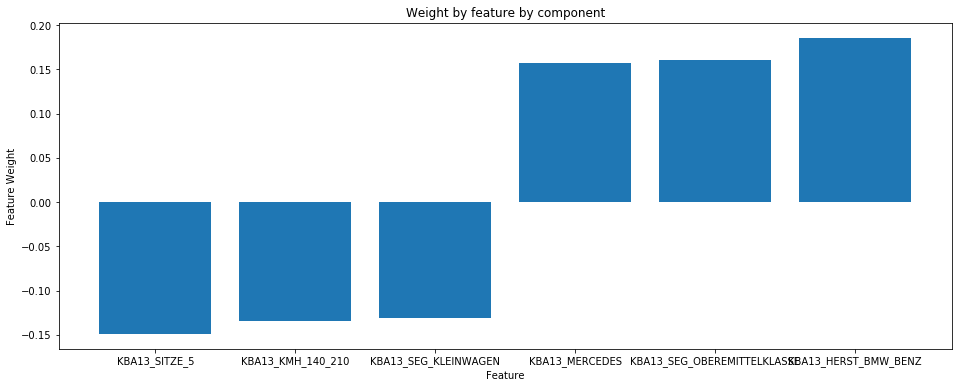

In [148]:
plot_weights_by_component(1,result)
plt.savefig('PC_2_Features_Weight.png',bbox_inches = 'tight')
plt.show()

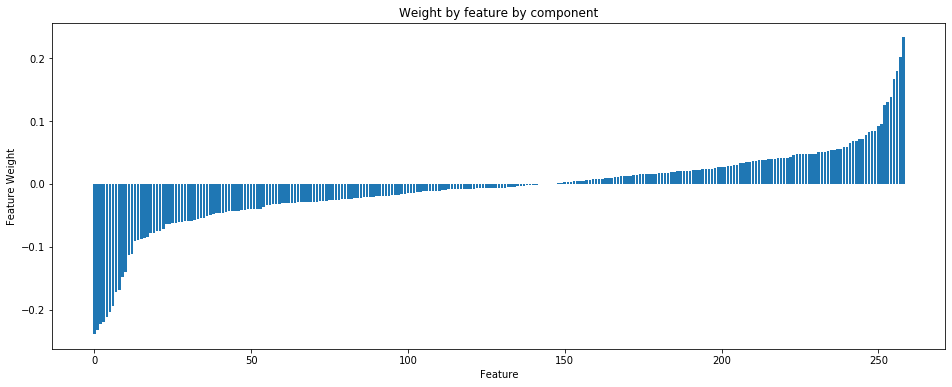

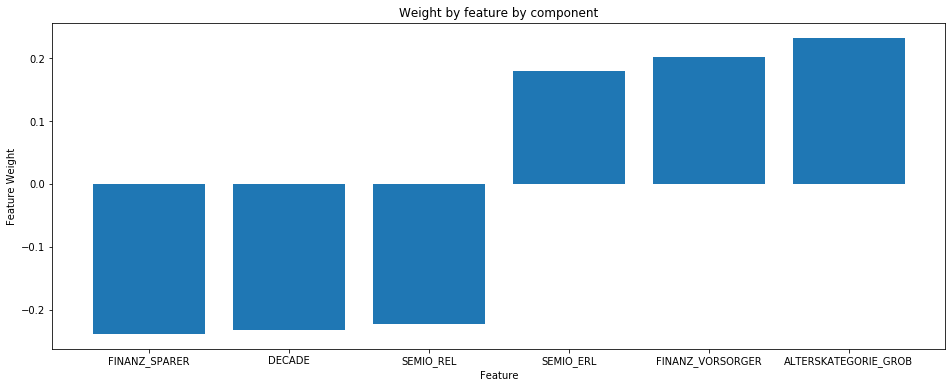

In [149]:
plot_weights_by_component(2,result)
plt.savefig('PC_3_Features_Weight.png',bbox_inches = 'tight')
plt.show()

Interpreting principal components is based on finding out which variables are correlated with each component. For those variables that are positively correlated to a principal component, it means that they vary together in such as if one increases the other variables increase as well. The first pricipal component is postively correlated to:

1. PLZ8_ANTG3:number of 6–10 family houses in the PLZ8
2. KBA13_ANTG3:number of >10 family houses in the PLZ8
3. KBA13_ANTG4: Description of this was feature was not available

And negatively correlated to:
1. PLZ8_ANTG1:Number of 1–2 family houses in the cell
2. KBA13_ANTG1: No description found
3. MOBI_REGIO: Moving patterns

The second component is positively related to:
1. KBA13_HERST_BMW_BENZ: Share of Volkswagen & Audi within the PLZ8
2. KBA13_SEG_OBEREMITTELKLASSE: Share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)
3. KBA13_MERCEDES: Share of MERCEDES within the PLZ8

And negatively correlated to :
1. KBA13_SITZE_5: Number of cars with 5 seats in the PLZ8
2. KB13_KMH_140_210: Share of cars with max speed between 140 and 210km/hr within the PLZ8
3. KBA13_SEG_KLEINWAGEN: Share of small and very small cars(Ford Fiesta, Ford Ka etx) in the PLZ8

The third component is positively related to:
1. ALTERSKATEGORIE_GROB:age classification through prename analysis
2. FINANZ_VORSORGER:Financial typology: be prepared
3. SEMIO_ERL:Affinity indicating in what way the person is eventful orientated

And negatively correlated to:
1. FINANZ_SPARER: money-saver
2. DECADE:Dominating movement in the person's youth (avantgarde or mainstream)
3. SEMIO_REL:Religious

#### Main findings among the features are:
1. Number of family members : The more it is, it encourages the spending nature
2. Share of upper middle class cars: Type of car (Share of BMW, Volkswagen, Mercedes and Audi) also defines that they are purchaser.
3. On the other other hand, money saver, religious mined and people who has small cars and also less mobility at their youth could be less spending. Although car speed is showing positive relation, but that could be investigated in further analysis.

## Clustering and Evaluation

In [89]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
cluster_nums = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
distances = []

def apply_kmeans(data, clusters):
    """
    Computed the average within-cluster distances. 
    
    INPUT:
    - data (array): the result from PCAs fit_transform function
    - clusters (int): number of clusters for k-means
            
    OUTPUT: None
    """
    
    kmeans = KMeans(n_clusters=clusters, random_state=12)
    preds = kmeans.fit_predict(data)
    pred_centroids = kmeans.cluster_centers_
    centers = pred_centroids[preds]
    distance = np.sqrt(((data - centers) ** 2).sum(axis = 1)).mean()
    distances.append(distance)
    print(distance)

In [90]:
%%time
for i in cluster_nums:
    apply_kmeans(X_azdias_pca,i)

15.382678298205128
14.798517937374587
14.565543458966093
14.397390307426395
14.27215185526537
14.172114318197986
14.08328387240396
14.014977818270975
13.954568215772133
13.910118526752392
13.865318462721243
13.825637438699575
13.791054800478932
13.761630856600645
13.74182519497407
13.707548215308185
13.688681361090042
13.665553678084695
13.633188359299071
13.609918131436709
CPU times: user 3h 34min 1s, sys: 18min 46s, total: 3h 52min 48s
Wall time: 3h 27min 43s


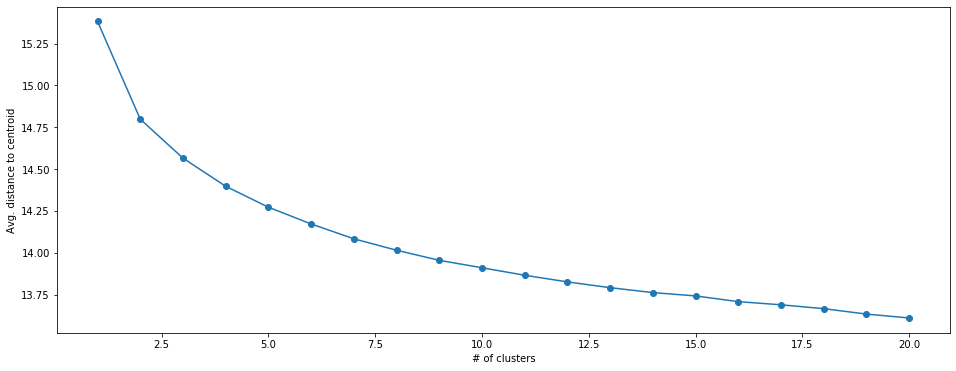

In [150]:
#Investigate the change in within-cluster distance across number of clusters (elbow method).
plt.plot(cluster_nums, distances, '-o')
plt.ylabel('Avg. distance to centroid')
plt.xlabel('# of clusters')
plt.savefig('distance_vs_clusters.png',bbox_inches = 'tight')
plt.show()

In [95]:
%%time
# run KMeans with the "optimal" number of clusters (from elbow method)
n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, random_state=12)
new_model =kmeans.fit(X_azdias_pca)
# for the general population
azdias_preds = kmeans.predict(X_azdias_pca)

CPU times: user 12min 5s, sys: 40.6 s, total: 12min 46s
Wall time: 12min 37s


In [96]:
%%time
# apply PCA to the customers dataset

X_customers_pca = pca_150.transform(customers_scaled)

CPU times: user 581 ms, sys: 617 ms, total: 1.2 s
Wall time: 1.19 s


In [97]:
# build a map for the general population, containing index and cluster predictions
#cluster_map_azdias = pd.DataFrame()
#cluster_map_azdias['data_index'] = azdias.index.values
#cluster_map_azdias['cluster'] = azdias_preds

In [98]:
%%time
# for the customers
customers_preds = new_model.predict(X_customers_pca)

CPU times: user 157 ms, sys: 15 ms, total: 172 ms
Wall time: 128 ms


In [99]:
customers_preds

array([4, 1, 4, ..., 4, 1, 5], dtype=int32)

In [100]:
# build a map for the customers, containing index and cluster predictions
#cluster_map_customers = pd.DataFrame()
#cluster_map_customers['data_index'] = customers.index.values
#cluster_map_customers['cluster'] = customers_preds

In [101]:

centers = new_model.cluster_centers_

In [102]:
centers.shape

(9, 150)

### Comparison between customer and general population proportion in clusters

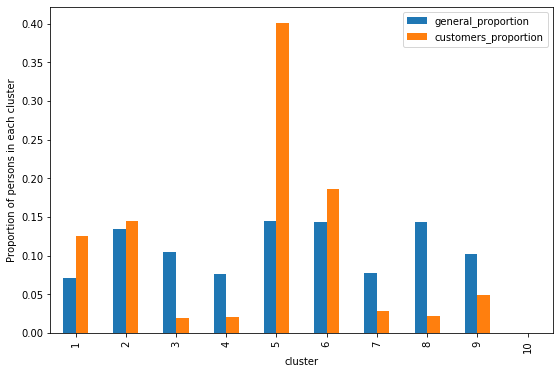

In [152]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
general_pop = []
customers_pop = []
x = [i+1 for i in range(10)]
for i in range(10):
    general_pop.append((azdias_preds == i).sum()/len(azdias_preds))
    customers_pop.append((customers_preds == i).sum()/len(customers_preds))


df_general = pd.DataFrame({'cluster' : x, 'general_proportion' : general_pop, 'customers_proportion':customers_pop})

#ax = sns.countplot(x='index', y = df_general['prop_1', 'prop_2'], data=df_general )
df_general.plot(x='cluster', y = ['general_proportion', 'customers_proportion'], kind='bar', figsize=(9,6))
plt.ylabel('Proportion of persons in each cluster')
plt.savefig('Cluster_proportion_gen_cus.png',bbox_inches = 'tight')
plt.show()

### Analyse features' weight in overrepresented and underrepresented group of customers in clusters

In [111]:
tt = pca_150.inverse_transform(new_model.cluster_centers_[1])
c_1 = tt
overrepresented = pd.Series(data = c_1, index = customers.columns).sort_values()
overrepresented

DECADE                        -0.723784
SEMIO_TRADV                   -0.659507
ONLINE_AFFINITAET             -0.650971
SEMIO_REL                     -0.642719
FINANZ_SPARER                 -0.618185
SEMIO_PFLICHT                 -0.609081
FINANZ_ANLEGER                -0.605484
FINANZ_UNAUFFAELLIGER         -0.577848
SEMIO_KULT                    -0.536170
MOBI_REGIO                    -0.518564
MOBI_RASTER                   -0.515721
KBA05_GBZ                     -0.494396
SEMIO_RAT                     -0.489373
KBA05_ANTG1                   -0.476954
LP_STATUS_GROB                -0.444824
SEMIO_FAM                     -0.418360
KBA05_KRSAQUOT                -0.414007
KBA05_ANHANG                  -0.406726
KBA05_AUTOQUOT                -0.381942
GREEN_AVANTGARDE              -0.366048
MOVEMENT                      -0.366048
SEMIO_MAT                     -0.342097
CJT_GESAMTTYP                 -0.342042
LP_FAMILIE_GROB               -0.303240
WOHNLAGE                      -0.290634


In [112]:
tt = pca_150.inverse_transform(new_model.cluster_centers_[5])
c_5 = tt
overrepresented = pd.Series(data = c_5, index = customers.columns).sort_values()
overrepresented

EWDICHTE                      -1.153137
KBA13_ANTG3                   -1.106991
PLZ8_ANTG3                    -1.074544
ORTSGR_KLS9                   -1.072515
ARBEIT                        -0.956607
KBA13_ANTG4                   -0.856251
PLZ8_ANTG4                    -0.852607
PLZ8_ANTG2                    -0.813457
RELAT_AB                      -0.804317
FINANZ_HAUSBAUER              -0.764181
KBA13_ANTG2                   -0.726464
KBA13_BAUMAX                  -0.667437
WEALTH                        -0.660989
PLZ8_BAUMAX                   -0.638087
CAMEO_DEUG_2015               -0.624683
KBA13_HERST_SONST             -0.554576
KBA13_FAB_SONSTIGE            -0.554576
KBA13_HALTER_30               -0.554048
KBA13_HALTER_66               -0.539451
KBA05_ANTG3                   -0.530115
KBA13_HHZ                     -0.527377
PLZ8_HHZ                      -0.504235
KBA13_ALTERHALTER_61          -0.502382
HH_EINKOMMEN_SCORE            -0.482905
KBA13_MAZDA                   -0.478520


In [114]:
tt = pca_150.inverse_transform(new_model.cluster_centers_[8])
c_8 = tt
underrepresented = pd.Series(data = c_8, index = customers.columns).sort_values()
underrepresented

KBA13_AUTOQUOTE               -1.412191
PLZ8_ANTG1                    -1.257025
KBA13_ANTG1                   -1.242824
KBA13_ALTERHALTER_60          -1.233436
KBA13_HALTER_55               -1.195563
KBA13_HALTER_60               -1.175347
KONSUMNAEHE                   -1.139300
INNENSTADT                    -1.129776
KBA13_KRSAQUOT                -1.102736
KBA13_GBZ                     -1.081055
MOBI_REGIO                    -1.075123
PLZ8_GBZ                      -1.072371
KBA05_AUTOQUOT                -1.046422
GEBAEUDETYP_RASTER            -1.044753
KBA05_GBZ                     -0.958371
KBA13_HALTER_20               -0.935301
KBA13_HALTER_50               -0.896460
BALLRAUM                      -0.884821
KBA05_ANTG1                   -0.884221
MOBI_RASTER                   -0.870769
LIFE_STAGE                    -0.859540
LP_STATUS_GROB                -0.775299
KBA13_SEG_MINIVANS            -0.750781
FINANZ_MINIMALIST             -0.669135
KBA05_ANHANG                  -0.661158


In [115]:
tt = pca_150.inverse_transform(new_model.cluster_centers_[3])
c_3 = tt
underrepresented = pd.Series(data = c_3, index = customers.columns).sort_values()
underrepresented

W                             -1.847659
KBA13_SITZE_4                 -1.476047
KBA13_HERST_BMW_BENZ          -1.361115
KBA13_MERCEDES                -1.337616
KBA13_SITZE_6                 -1.305281
KBA13_SEG_OBEREMITTELKLASSE   -1.261958
PLZ8_ANTG1                    -1.130521
KBA13_HALTER_45               -1.124415
KBA13_ANTG1                   -1.103869
KBA13_SEG_GELAENDEWAGEN       -1.102549
KBA13_SEG_GROSSRAUMVANS       -1.034073
KBA13_GBZ                     -0.998517
PLZ8_GBZ                      -0.982687
KBA13_BMW                     -0.972706
KBA13_SEG_UTILITIES           -0.946372
KBA13_SEG_SPORTWAGEN          -0.916977
KBA13_HERST_AUDI_VW           -0.913757
KBA05_ANTG1                   -0.904417
KBA05_HERST1                  -0.874119
KBA05_DIESEL                  -0.863198
MOBI_REGIO                    -0.853426
KBA13_AUTOQUOTE               -0.822834
KBA13_VW                      -0.814892
KBA05_CCM3                    -0.811039
KBA05_GBZ                     -0.793357



The above features' weight for overrepresented customers in general population certainly exhibit the idea where we can put our focus and acquire more customer.Indepth feature analysis will also give better explanation why these features are more likely to be important part of core business creation. For example, Cluster 5 has following three features with most positive weights.

| Feature  | Feature Meaning  | Weight  |
|---|---|---|
| KBA13_AUTOQUOTE  |  share of cars per household within the PLZ8 | 1.073699  |
| KBA05_ANHANG  | share of trailers in the microcell  | 0.951867  |
| KBA13_ANTG1 |No such description is found   | 0.946930  |


> The above features tells that share of car per household in PLZ8 is an important factor due to the fact that they define the mobility.

> Cluster 1 has the following three features with most positive weights :

|Feature   |Feature Meaning   | Weight  |
|---|---|---|
| FINANZ_VORSORGER  | financial typology: be prepared  |  0.777393 |
| ALTERSKATEGORIE_GROB  | age classification through prename analysis  | 0.694056  |
| RETOURTYP_BK_S  | return type  |  0.580153 |


> Another type of customer are prepared financially. Obviously age is another important criteria to predict and be defined as customers.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';',dtype={18:'str',19:'str'})

In [118]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [119]:
diff_not_in_mailout = list(set(mailout_train) - set(feat_list))
print('Features in mailout that are not in feat_list:')
print(len(diff_not_in_mailout))
print(diff_not_in_mailout)
print('***')

Features in mailout that are not in feat_list:
33
['D19_KONSUMTYP_MAX', 'RT_KEIN_ANREIZ', 'LNR', 'VK_DHT4A', 'VHN', 'ALTER_KIND2', 'RESPONSE', 'VK_ZG11', 'RT_SCHNAEPPCHEN', 'STRUKTURTYP', 'RT_UEBERGROESSE', 'VHA', 'CJT_TYP_2', 'ALTER_KIND4', 'CJT_TYP_1', 'ALTER_KIND1', 'D19_LETZTER_KAUF_BRANCHE', 'CJT_TYP_3', 'CJT_KATALOGNUTZER', 'UMFELD_ALT', 'GEMEINDETYP', 'VERDICHTUNGSRAUM', 'CJT_TYP_5', 'CJT_TYP_4', 'EXTSEL992', 'EINGEFUEGT_AM', 'CJT_TYP_6', 'UMFELD_JUNG', 'FIRMENDICHTE', 'AKT_DAT_KL', 'KOMBIALTER', 'VK_DISTANZ', 'ALTER_KIND3']
***


In [120]:
# Imbalance of REPONSE column
vc = mailout_train['RESPONSE'].value_counts()

In [121]:
# positive response
vc[1]/(vc[0]+vc[1])

0.012383036171500396

In [122]:
# negative response
vc[0]/(vc[0]+vc[1])

0.9876169638284996

In [123]:
# extract RESPONSE column
y = mailout_train['RESPONSE']
mailout_train.drop(labels=['RESPONSE'], axis=1, inplace=True)


In [176]:
y.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [124]:
#  copied from output Part 0 - Step 1
features_not_described = ['VHN', 'D19_KONSUMTYP_MAX', 'VHA', 'D19_LETZTER_KAUF_BRANCHE', 'GEMEINDETYP', 'VK_DHT4A', 'ALTER_KIND4', 'LNR', 'RT_UEBERGROESSE', 'EINGEFUEGT_AM', 'STRUKTURTYP', 'FIRMENDICHTE', 'UMFELD_JUNG', 'ALTER_KIND1', 'CJT_TYP_2', 'CJT_TYP_5', 'CJT_TYP_3', 'AKT_DAT_KL', 'UMFELD_ALT', 'CJT_KATALOGNUTZER', 'CJT_TYP_6', 'RT_KEIN_ANREIZ', 'CJT_TYP_4', 'RT_SCHNAEPPCHEN', 'KOMBIALTER', 'ALTER_KIND2', 'VK_ZG11', 'CJT_TYP_1', 'EXTSEL992', 'VK_DISTANZ', 'ALTER_KIND3', 'VERDICHTUNGSRAUM']

In [125]:
set(features_not_described) - set(diff_not_in_mailout)



set()

In [126]:

# find features to drop because of many missing values
missing_per_column = mailout_train.isnull().mean()


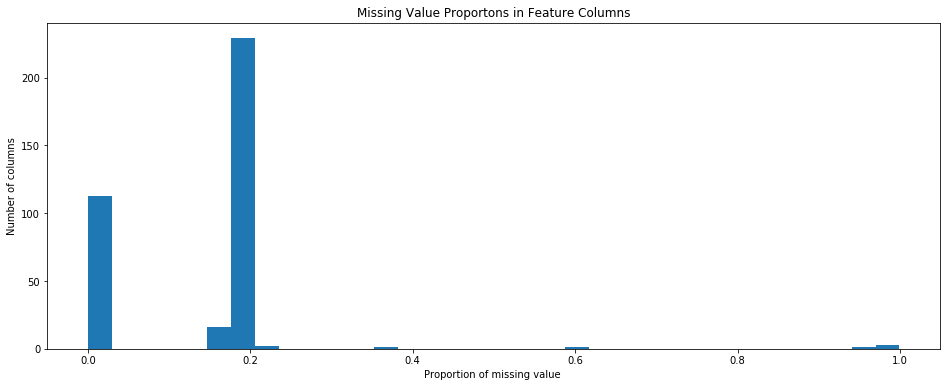

In [155]:
#plot missing proportion per column
plt.hist(missing_per_column, bins=34)
plt.title("Missing Value Proportons in Feature Columns")
plt.xlabel('Proportion of missing value ')
plt.ylabel('Number of columns');


In [128]:
# define threshold, might be different to the threshold in Part 1
# output shows that other features than in Part 1 should be dropped
drop_missing_per_column = missing_per_column[missing_per_column > 0.25].index
drop_missing_per_column = list(set(drop_missing_per_column) - set(features_not_described))
drop_missing_per_column

['KK_KUNDENTYP']

In [129]:
# clean data, no splitting of rows necessary
mailout_train = clean_data(mailout_train, feat_info, features_not_described, drop_missing_per_column)
mailout_train.shape


(42962, 331)

In [130]:

# impute median and scale azdias
imputer= Imputer(strategy='median')
scaler = StandardScaler()



/Users/lailashahreen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [131]:
#Apply imputation and scaling
mailout_train_imputed = pd.DataFrame(imputer.fit_transform(mailout_train))
mailout_train_scaled = scaler.fit_transform(mailout_train_imputed)

mailout_train_scaled.shape


(42962, 331)

## Model Training 

In [132]:
def classifier_grid(clf, param_grid, X_train=mailout_train_scaled, y_train=y):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

### Logistic Regression

In [133]:
# LogisticRegression
clf_a = LogisticRegression(random_state=12)
classifier_grid(clf_a, {})



/Users/lailashahreen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lailashahreen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lailashahreen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lailashahreen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lailashahreen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:

0.7370796924641789


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### RandomForestClassifier

In [214]:
%%time
# RandomForestClassifier
clf_b = RandomForestClassifier(random_state=12)
classifier_grid(clf_b, {})



/Users/lailashahreen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lailashahreen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lailashahreen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lailashahreen/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarni

0.5353909402083376
CPU times: user 10.7 s, sys: 588 ms, total: 11.2 s
Wall time: 11.5 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

### GradientBoostingClassifier

In [134]:
%%time
#GradientBoostingClassifier
clf_c = GradientBoostingClassifier(random_state=12)
classifier_grid(clf_c, {})


0.7645335908544074
CPU times: user 7min, sys: 1.89 s, total: 7min 2s
Wall time: 7min 5s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=12, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### AdaBoostClassifier

In [135]:
%%time
# AdaBoostClassifier
clf_d = AdaBoostClassifier(random_state=12)
classifier_grid(clf_d, {})


0.7437538921803157
CPU times: user 1min 39s, sys: 4.95 s, total: 1min 44s
Wall time: 1min 44s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=12)

### Model Tuning

In [159]:
%%time
# initialize the best classifier
clf = GradientBoostingClassifier(random_state=12)
param_grid = {'loss': ['deviance', 'exponential'],
              'max_depth': [2, 3],
              'n_estimators':[80],
              'random_state': [12]}
             
    


clf_best_est = classifier_grid(clf, param_grid)
clf_best_est

0.7700992948209882
CPU times: user 17min 46s, sys: 8.73 s, total: 17min 54s
Wall time: 18min 12s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=80,
                           n_iter_no_change=None, presort='auto',
                           random_state=12, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [160]:
%%time
clf_a = AdaBoostClassifier(random_state=12)
param_grid = {'n_estimators':[50,100],
             'learning_rate': [1.0, 0.05]
             }


clf_a_best_est = classifier_grid(clf_a, param_grid)
clf_a_best_est

0.7621757100268067
CPU times: user 9min 50s, sys: 30.1 s, total: 10min 20s
Wall time: 10min 30s


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.05,
                   n_estimators=100, random_state=12)

### Feature Importance

Since the GradientBoostingClassifier gave better  ROC/AUC score, I am keepig this as final model for testing other dataset.

In [162]:
feat_importance = clf_best_est.feature_importances_
feat_importance

array([0.        , 0.02717247, 0.00228521, 0.00280342, 0.00174711,
       0.08330033, 0.00147525, 0.0044523 , 0.00517954, 0.        ,
       0.        , 0.00232626, 0.00231169, 0.01156374, 0.00495158,
       0.        , 0.        , 0.        , 0.04252318, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00820146, 0.        , 0.        ,
       0.        , 0.        , 0.04117685, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00194188, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.46837947, 0.00511379, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00314009,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00892714, 0.        , 0.00238

['D19_SOZIALES' 'ANZ_KINDER' 'D19_BANKEN_LOKAL' 'D19_GARTEN' nan]
[0.46837947 0.08330033 0.04252318 0.04117685 0.03219858]


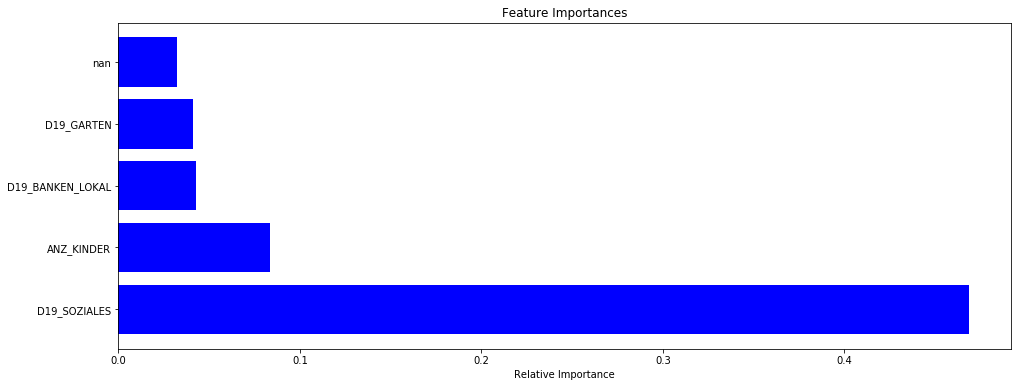

In [175]:
num_feat = 5

indices = np.argsort(feat_importance)[::-1]
columns = mailout_train.columns.values[indices[:num_feat]]
values = feat_importance[indices][:num_feat]

#print((indices))
print(columns)
print(values)

plt.title('Feature Importances')
plt.barh(np.arange(num_feat), values, color='b', align='center', label = "Feature Weight")


plt.yticks(np.arange(num_feat), columns)
plt.xlabel('Relative Importance')
plt.savefig('Feature_Importance.png')
plt.show()


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [165]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';',dtype={18:'str',19:'str'})
#mailout_test = pd.read_csv('mailout_test.csv')

/Users/lailashahreen/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [166]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.6+ MB


In [167]:

mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

### Data Preprocessing

In [168]:
# extract lnr for later generation of the competition result file
lnr = mailout_test.LNR

In [169]:
# clean data
mailout_test = clean_data(mailout_test, feat_info, features_not_described, drop_missing_per_column)
mailout_test.shape

(42833, 331)

In [170]:
# impute median and scale azdias 
mailout_test_imputed = pd.DataFrame(imputer.transform(mailout_test))
mailout_test_scaled = scaler.transform(mailout_test_imputed)

### Classification

In [172]:

# use the trained model from Part 2 to predict the probabilties of the testing data 
response_test = clf_best_est.predict_proba(mailout_test_scaled)
response_test

array([[0.96905772, 0.03094228],
       [0.96761689, 0.03238311],
       [0.99739388, 0.00260612],
       ...,
       [0.97917962, 0.02082038],
       [0.97111539, 0.02888461],
       [0.98121209, 0.01878791]])

### Output file for Kaggle competition

In [173]:
# generate result file for the competition
result = pd.DataFrame({'LNR':lnr, 'RESPONSE':response_test[:,0]})
result.to_csv(path_or_buf='./result.csv', index=False)
result.head(10)

,LNR,RESPONSE
0,1754,0.969058
1,1770,0.967617
2,1465,0.997394
3,1470,0.998258
4,1478,0.998053
5,1782,0.996797
6,1485,0.997809
7,1519,0.976083
8,1835,0.978345
9,1522,0.997177
